## Import Packages

In [5]:
import os
import pickle
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import PandasTools

import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from deepchem.feat.smiles_tokenizer import SmilesTokenizer, BasicSmilesTokenizer


import sys
curr_dir = os.path.abspath(".")
util_dir = os.path.join(os.path.dirname(curr_dir))
sys.path.append(util_dir)
from utils.models import SMILESModel as Model

## Curate Dataset

In [12]:
class SMILESDataset(Dataset):
    def __init__(self, df, augment=True):
        self.all_df = df
        self.augment = augment

    def _featurize(self, mol):
        smi = Chem.MolToSmiles(mol, doRandom=self.augment)
        return smi
    
    def __getitem__(self, idx):
        mol = self.all_df.iloc[idx]["ROMol"]
        smi = self._featurize(mol)
        pka = self.all_df.iloc[idx]["pKa"]
        return smi, pka
    
    def __len__(self):
        return self.all_df.shape[0]


class Collate:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def collate(self, data):
        smis = [smi for smi, pka in data]
        max_len = max([len(smi) for smi in smis])
        padded_smis = [smi+["[PAD]"]*(max_len-len(smi)) for smi in smis]
        X = [self.tokenizer.encode(smi) for smi in padded_smis]
        X = torch.Tensor(X, dtype=torch.long)
        Y = torch.Tensor([pka for smi, pka in data], dtype=torch.float)
        return X, Y

In [14]:
infile = "../data/combined_training_datasets_unique.sdf"
vocab_path = "../data/vocab.txt"
all_df = PandasTools.LoadSDF(infile)
name = os.path.splitext(os.path.basename(infile))[0]
tokenizer = SmilesTokenizer(vocab_path)
print(tokenizer.vocab)

[16:28:37] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 13 ignored


OrderedDict([('[PAD]', 0), ('[unused1]', 1), ('[unused2]', 2), ('[unused3]', 3), ('[unused4]', 4), ('[unused5]', 5), ('[unused6]', 6), ('[unused7]', 7), ('[unused8]', 8), ('[unused9]', 9), ('[unused10]', 10), ('[UNK]', 11), ('[CLS]', 12), ('[SEP]', 13), ('[MASK]', 14), ('c', 15), ('C', 16), ('(', 17), (')', 18), ('O', 19), ('1', 20), ('2', 21), ('=', 22), ('N', 23), ('.', 24), ('n', 25), ('3', 26), ('F', 27), ('Cl', 28), ('>>', 29), ('~', 30), ('-', 31), ('4', 32), ('[C@H]', 33), ('S', 34), ('[C@@H]', 35), ('[O-]', 36), ('Br', 37), ('#', 38), ('/', 39), ('[nH]', 40), ('[N+]', 41), ('s', 42), ('5', 43), ('o', 44), ('P', 45), ('[Na+]', 46), ('[Si]', 47), ('I', 48), ('[Na]', 49), ('[Pd]', 50), ('[K+]', 51), ('[K]', 52), ('[P]', 53), ('B', 54), ('[C@]', 55), ('[C@@]', 56), ('[Cl-]', 57), ('6', 58), ('[OH-]', 59), ('\\', 60), ('[N-]', 61), ('[Li]', 62), ('[H]', 63), ('[2H]', 64), ('[NH4+]', 65), ('[c-]', 66), ('[P-]', 67), ('[Cs+]', 68), ('[Li+]', 69), ('[Cs]', 70), ('[NaH]', 71), ('[H-]', 

/home/mxue33/anaconda3/envs/sphinx/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Recurrent Neural Network

In [19]:
# for reproduce purposes
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

datadir = "."
ratio = 0.1
batch_size = 256
augment = True
vocab_size = len(tokenizer.vocab)
device = "cuda" if torch.cuda.is_available() else "cpu"

## Split Dataset

In [18]:
# split
nsamples = all_df.shape[0]
val_size = int(nsamples*ratio)
print(f"Number of samples: {nsamples}")
df_train = all_df.iloc[:-val_size]
df_test = all_df.iloc[-val_size:]
print(f"Size of training set: {df_train.shape[0]}, Size of test set: {df_test.shape[0]}")
## batching
instance = Collate(tokenizer)
collate_fn = instance.collate
train_loader = DataLoader(SMILESDataset(df_train, augment), \
    batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(SMILESDataset(df_test, augment), \
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Number of samples: 5994
Size of training set: 5395, Size of test set: 599


## Model

In [2]:
def train_epoch(dataloader, model, loss_func, optimizer, device):
    model.train()
    train_loss = []
    for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

def val_epoch(dataloader, loss_func, model, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            val_loss.append(loss.detach().cpu().numpy())
    return np.mean(val_loss)

## Training

In [ ]:
epochs = 20
lr = 1e-2

model = Model(vocab_size, hidden_dims=[100, 50, 20])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.functional.mse_loss

train_epoch_losses, test_epoch_losses = [], []
for n in range(epochs):
    train_epoch_loss = train_epoch(train_loader, model, loss_func, optimizer, device)
    val_epoch_loss = val_epoch(test_loader, loss_func, model, device)
    train_epoch_losses.append(train_epoch_loss)
    test_epoch_losses.append(val_epoch_loss)

In [ ]:
plt.plot(train_epoch_losses, label="Train")
plt.plot(test_epoch_losses, label="Test")
plt.legend()

## Analysis

tensor(2.4052)


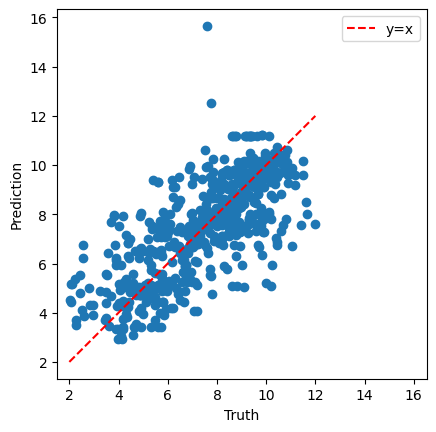

In [ ]:
model.eval()
with torch.no_grad():
    truth = df_test["pKa"].values.tolist()
    pred = []
    for mol in df_test["ROMol"].to_list():
        smi = Chem.MolToSmiles(mol, doRandom=True)
        tensor = torch.Tensor(tokenizer.encode(smi)).reshape(1, -1)
        p = model(tensor.long())
        pred.append(p)
    l = nn.functional.mse_loss(pred, truth)
    print(l)

xreg = np.linspace(2, 12, num=100)
yreg = xreg
plt.plot(xreg, yreg, 'r--', label="y=x")
plt.scatter(truth, pred)
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.axis("square")
plt.legend()